# Question 1: “What health conditions and lifestyle factors commonly occur together in individuals with different diabetes diagnoses?”

## Importing Python libraries and the Initial Dataset

### Importing Python libraries

In [35]:
#%pip install pandas mlxtend matplotlib seaborn
#%pip install imbalanced-learn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import networkx as nx
from sklearn.model_selection import train_test_split
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
import networkx as nx
import matplotlib.pyplot as plt


### Importing the cleaned dataset from desktop folder

In [36]:
def read_csv_file(file_path):
    """
    Read a CSV file into a pandas DataFrame.

    Parameters:
    file_path (str): The path to the CSV file.

    Returns:
    pandas.DataFrame: The DataFrame containing the data from the CSV file.
    """
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)

    return df

# Specify the file path
file_path = 'C:/Users/steph/OneDrive/Desktop/Diabetes/archive/diabetes_012_health_indicators_BRFSS2015_cleaned.csv'

# Read the CSV file into a pandas DataFrame
df = read_csv_file(file_path)

# Display the DataFrame
display(df.head())

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0,1,1,1,40.0,1,0,0,0,0,...,1,0,5,18,15,1,0,9,4,3
1,0,0,0,0,25.0,1,0,0,1,0,...,0,1,3,0,0,0,0,7,6,1
2,0,1,1,1,28.0,0,0,0,0,1,...,1,1,5,30,30,1,0,9,4,8
3,0,1,0,1,27.0,0,0,0,1,1,...,1,0,2,0,0,0,0,11,3,6
4,0,1,1,1,24.0,0,0,0,1,1,...,1,0,2,3,0,0,0,11,5,4


## Preparing the Data
The apriori algorithm that I will be using requires a binary matrix format for its operations. We will be applying one-hot encoding to separate the data into binary columns with binary values 0 and 1 and treat each category as distinct items, one for each catagory of interest for the analysis. 
 

### One Hot Encoding the Diabetes Target Variable

In [37]:
#One-hot encoding the Diabetes_012 column into three binary columsn called diabetes_0, diabetes_1, and diabetes_2
df_encoded = pd.get_dummies(df, columns=['Diabetes_012'], prefix='diabetes')

# Convert the boolean values in the diabetes columns to integers (0/1)
df_encoded['diabetes_0'] = df_encoded['diabetes_0'].astype(int)
df_encoded['diabetes_1'] = df_encoded['diabetes_1'].astype(int)
df_encoded['diabetes_2'] = df_encoded['diabetes_2'].astype(int)

#Verify the changes
display(df_encoded.head())

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income,diabetes_0,diabetes_1,diabetes_2
0,1,1,1,40.0,1,0,0,0,0,1,...,18,15,1,0,9,4,3,1,0,0
1,0,0,0,25.0,1,0,0,1,0,0,...,0,0,0,0,7,6,1,1,0,0
2,1,1,1,28.0,0,0,0,0,1,0,...,30,30,1,0,9,4,8,1,0,0
3,1,0,1,27.0,0,0,0,1,1,1,...,0,0,0,0,11,3,6,1,0,0
4,1,1,1,24.0,0,0,0,1,1,1,...,3,0,0,0,11,5,4,1,0,0


### One Hot Encoding BMI Categories

In [38]:
#Dividing BMI into 6 categories based on CDC guidelines: https://www.cdc.gov/bmi/adult-calculator/bmi-categories.html
df_encoded['BMI'] = pd.cut(df_encoded['BMI'], bins=[0, 18.4, 24.9, 29.9, 34.9, 39.9, 100], labels=['Underweight', 'Healthy weight', 'Overweight', 'Class 1 Obesity', 'Class 2 Obesity', 'Class 3 Obesity'])

#One-hot encoding the BMI column into 6 binary columsn 
df_encoded = pd.get_dummies(df_encoded, columns=['BMI'])

# Convert the boolean values in the BMI columns to integers (0/1)
df_encoded['BMI_Underweight'] = df_encoded['BMI_Underweight'].astype(int)
df_encoded['BMI_Healthy weight'] = df_encoded['BMI_Healthy weight'].astype(int)
df_encoded['BMI_Overweight'] = df_encoded['BMI_Overweight'].astype(int)
df_encoded['BMI_Class 1 Obesity'] = df_encoded['BMI_Class 1 Obesity'].astype(int)
df_encoded['BMI_Class 2 Obesity'] = df_encoded['BMI_Class 2 Obesity'].astype(int)
df_encoded['BMI_Class 3 Obesity'] = df_encoded['BMI_Class 3 Obesity'].astype(int)

#Verify the changes
display(df_encoded.head())

,HighBP,HighChol,CholCheck,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,...,Income,diabetes_0,diabetes_1,diabetes_2,BMI_Underweight,BMI_Healthy weight,BMI_Overweight,BMI_Class 1 Obesity,BMI_Class 2 Obesity,BMI_Class 3 Obesity
0,1,1,1,1,0,0,0,0,1,0,...,3,1,0,0,0,0,0,0,0,1
1,0,0,0,1,0,0,1,0,0,0,...,1,1,0,0,0,0,1,0,0,0
2,1,1,1,0,0,0,0,1,0,0,...,8,1,0,0,0,0,1,0,0,0
3,1,0,1,0,0,0,1,1,1,0,...,6,1,0,0,0,0,1,0,0,0
4,1,1,1,0,0,0,1,1,1,0,...,4,1,0,0,0,1,0,0,0,0


### One Hot Encoding GenHlth

In [39]:
#One-hot encoding the GenHlth column into 5 binary columns 
df_encoded = pd.get_dummies(df_encoded, columns=['GenHlth'], prefix='GenHlth')

# Convert the boolean values in the GENHLTH columns to integers (0/1)
df_encoded['GenHlth_1'] = df_encoded['GenHlth_1'].astype(int)
df_encoded['GenHlth_2'] = df_encoded['GenHlth_2'].astype(int)
df_encoded['GenHlth_3'] = df_encoded['GenHlth_3'].astype(int)
df_encoded['GenHlth_4'] = df_encoded['GenHlth_4'].astype(int)
df_encoded['GenHlth_5'] = df_encoded['GenHlth_5'].astype(int)

#Rename the columns to be more descriptive where 5 = poor, 4 =  fair, 3 = good, 2 = very good, 1 = excellent
df_encoded.rename(columns = {'GenHlth_1': 'GenHlth_Excellent', 'GenHlth_2': 'GenHlth_Very good', 'GenHlth_3': 'GenHlth_Good', 'GenHlth_4': 'GenHlth_Fair', 'GenHlth_5': 'GenHlth_Poor'}, inplace = True)

#Verify the changes
display(df_encoded.head())

,HighBP,HighChol,CholCheck,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,...,BMI_Healthy weight,BMI_Overweight,BMI_Class 1 Obesity,BMI_Class 2 Obesity,BMI_Class 3 Obesity,GenHlth_Excellent,GenHlth_Very good,GenHlth_Good,GenHlth_Fair,GenHlth_Poor
0,1,1,1,1,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,1
1,0,0,0,1,0,0,1,0,0,0,...,0,1,0,0,0,0,0,1,0,0
2,1,1,1,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,1
3,1,0,1,0,0,0,1,1,1,0,...,0,1,0,0,0,0,1,0,0,0
4,1,1,1,0,0,0,1,1,1,0,...,1,0,0,0,0,0,1,0,0,0


### One Hot Encoding MentHlth

In [40]:
# Dividing MentHlth into 7 categories where the first category is for containing 0 only and the last category goes up to 30
df_encoded['MentHlth'] = pd.cut(df_encoded['MentHlth'], bins=[-1, 0, 5, 10, 15, 20, 25, 30], labels=['0', '1-5', '6-10', '11-15', '16-20', '21-25', '26-30'])

#One hot encoding the MentHlth column into 7 binary columns
df_encoded = pd.get_dummies(df_encoded, columns=['MentHlth'], prefix='MentHlth')

# Convert the boolean values in the MentHlth columns to integers (0/1)
df_encoded['MentHlth_0'] = df_encoded['MentHlth_0'].astype(int)
df_encoded['MentHlth_1-5'] = df_encoded['MentHlth_1-5'].astype(int)
df_encoded['MentHlth_6-10'] = df_encoded['MentHlth_6-10'].astype(int)
df_encoded['MentHlth_11-15'] = df_encoded['MentHlth_11-15'].astype(int)
df_encoded['MentHlth_16-20'] = df_encoded['MentHlth_16-20'].astype(int)
df_encoded['MentHlth_21-25'] = df_encoded['MentHlth_21-25'].astype(int)
df_encoded['MentHlth_26-30'] = df_encoded['MentHlth_26-30'].astype(int)

#Verify the changes
display(df_encoded.head())

,HighBP,HighChol,CholCheck,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,...,GenHlth_Good,GenHlth_Fair,GenHlth_Poor,MentHlth_0,MentHlth_1-5,MentHlth_6-10,MentHlth_11-15,MentHlth_16-20,MentHlth_21-25,MentHlth_26-30
0,1,1,1,1,0,0,0,0,1,0,...,0,0,1,0,0,0,0,1,0,0
1,0,0,0,1,0,0,1,0,0,0,...,1,0,0,1,0,0,0,0,0,0
2,1,1,1,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1
3,1,0,1,0,0,0,1,1,1,0,...,0,0,0,1,0,0,0,0,0,0
4,1,1,1,0,0,0,1,1,1,0,...,0,0,0,0,1,0,0,0,0,0


### One Hot Encoding PhysHlth

In [41]:
# Dividing PhysHlth into 7 categories where the first category is for containing 0 only and the last category goes up to 30
df_encoded['PhysHlth'] = pd.cut(df_encoded['PhysHlth'], bins=[-1, 0, 5, 10, 15, 20, 25, 30], labels=['0', '1-5', '6-10', '11-15', '16-20', '21-25', '26-30'])

#One hot encoding the PhysHlth column into 7 binary columns
df_encoded = pd.get_dummies(df_encoded, columns=['PhysHlth'], prefix='PhysHlth')

# Convert the boolean values in the PhysHlth columns to integers (0/1)
df_encoded['PhysHlth_0'] = df_encoded['PhysHlth_0'].astype(int)
df_encoded['PhysHlth_1-5'] = df_encoded['PhysHlth_1-5'].astype(int)
df_encoded['PhysHlth_6-10'] = df_encoded['PhysHlth_6-10'].astype(int)
df_encoded['PhysHlth_11-15'] = df_encoded['PhysHlth_11-15'].astype(int)
df_encoded['PhysHlth_16-20'] = df_encoded['PhysHlth_16-20'].astype(int)
df_encoded['PhysHlth_21-25'] = df_encoded['PhysHlth_21-25'].astype(int)
df_encoded['PhysHlth_26-30'] = df_encoded['PhysHlth_26-30'].astype(int)

#Verify the changes
display(df_encoded.head())

,HighBP,HighChol,CholCheck,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,...,MentHlth_16-20,MentHlth_21-25,MentHlth_26-30,PhysHlth_0,PhysHlth_1-5,PhysHlth_6-10,PhysHlth_11-15,PhysHlth_16-20,PhysHlth_21-25,PhysHlth_26-30
0,1,1,1,1,0,0,0,0,1,0,...,1,0,0,0,0,0,1,0,0,0
1,0,0,0,1,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,1,1,1,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1
3,1,0,1,0,0,0,1,1,1,0,...,0,0,0,1,0,0,0,0,0,0
4,1,1,1,0,0,0,1,1,1,0,...,0,0,0,1,0,0,0,0,0,0


### One Hot Encoding Age

In [42]:
#One Hot Encoding the Age column 
df_encoded = pd.get_dummies(df_encoded, columns=['Age'], prefix='Age')

# Convert the boolean values in the Age columns to integers (0/1)
df_encoded['Age_1'] = df_encoded['Age_1'].astype(int)
df_encoded['Age_2'] = df_encoded['Age_2'].astype(int)
df_encoded['Age_3'] = df_encoded['Age_3'].astype(int)
df_encoded['Age_4'] = df_encoded['Age_4'].astype(int)
df_encoded['Age_5'] = df_encoded['Age_5'].astype(int)
df_encoded['Age_6'] = df_encoded['Age_6'].astype(int)
df_encoded['Age_7'] = df_encoded['Age_7'].astype(int)
df_encoded['Age_8'] = df_encoded['Age_8'].astype(int)
df_encoded['Age_9'] = df_encoded['Age_9'].astype(int)
df_encoded['Age_10'] = df_encoded['Age_10'].astype(int)
df_encoded['Age_11'] = df_encoded['Age_11'].astype(int)
df_encoded['Age_12'] = df_encoded['Age_12'].astype(int)
df_encoded['Age_13'] = df_encoded['Age_13'].astype(int)

#Rename the columns to be more descriptive
df_encoded.rename(columns = {'Age_1': 'Age_18-24', 'Age_2': 'Age_25-29', 'Age_3': 'Age_30-34', 'Age_4': 'Age_35-39', 'Age_5': 'Age_40-44', 'Age_6': 'Age_45-49', 'Age_7': 'Age_50-54', 'Age_8': 'Age_55-59', 'Age_9': 'Age_60-64', 'Age_10': 'Age_65-69', 'Age_11': 'Age_70-74', 'Age_12': 'Age_75-79', 'Age_13': 'Age_80 or older'}, inplace = True)

#Verify the changes
display(df_encoded.head())



,HighBP,HighChol,CholCheck,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,...,Age_35-39,Age_40-44,Age_45-49,Age_50-54,Age_55-59,Age_60-64,Age_65-69,Age_70-74,Age_75-79,Age_80 or older
0,1,1,1,1,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
1,0,0,0,1,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,1,1,1,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,1,0,1,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,1,0,0
4,1,1,1,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,1,0,0


### One Hot Encoding Education

In [43]:
#One Hot Encoding the Education column
df_encoded = pd.get_dummies(df_encoded, columns=['Education'], prefix='Education')

# Convert the boolean values in the Education columns to integers (0/1)
df_encoded['Education_1'] = df_encoded['Education_1'].astype(int)
df_encoded['Education_2'] = df_encoded['Education_2'].astype(int)
df_encoded['Education_3'] = df_encoded['Education_3'].astype(int)
df_encoded['Education_4'] = df_encoded['Education_4'].astype(int)
df_encoded['Education_5'] = df_encoded['Education_5'].astype(int)
df_encoded['Education_6'] = df_encoded['Education_6'].astype(int)

#Rename the columns to be more descriptive
df_encoded.rename(columns = {'Education_1': 'Education_Never attended school or only kindergarten', 'Education_2': 'Education_Elementary', 'Education_3': 'Education_Some high school', 'Education_4': 'Education_High school graduate', 'Education_5': 'Education_Some college or technical school', 'Education_6': 'Education_College graduate'}, inplace = True)

#Verify the changes
display(df_encoded.head())

,HighBP,HighChol,CholCheck,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,...,Age_65-69,Age_70-74,Age_75-79,Age_80 or older,Education_Never attended school or only kindergarten,Education_Elementary,Education_Some high school,Education_High school graduate,Education_Some college or technical school,Education_College graduate
0,1,1,1,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,1,1,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
3,1,0,1,0,0,0,1,1,1,0,...,0,1,0,0,0,0,1,0,0,0
4,1,1,1,0,0,0,1,1,1,0,...,0,1,0,0,0,0,0,0,1,0


### One Hot Encoding Income

In [44]:
#One Hot Encoding the Income column
df_encoded = pd.get_dummies(df_encoded, columns=['Income'], prefix='Income')

# Convert the boolean values in the Income columns to integers (0/1)
df_encoded['Income_1'] = df_encoded['Income_1'].astype(int)
df_encoded['Income_2'] = df_encoded['Income_2'].astype(int)
df_encoded['Income_3'] = df_encoded['Income_3'].astype(int)
df_encoded['Income_4'] = df_encoded['Income_4'].astype(int)
df_encoded['Income_5'] = df_encoded['Income_5'].astype(int)
df_encoded['Income_6'] = df_encoded['Income_6'].astype(int)
df_encoded['Income_7'] = df_encoded['Income_7'].astype(int)
df_encoded['Income_8'] = df_encoded['Income_8'].astype(int)

#Rename the columns to be more descriptive
df_encoded.rename(columns = {'Income_1': 'Income_Less than $10,000', 'Income_2': 'Income_$10,000-$14,999', 'Income_3': 'Income_$15,000-$19,999', 'Income_4': 'Income_$20,000-$24,999', 'Income_5': 'Income_$25,000-$34,999', 'Income_6': 'Income_$35,000-$49,999', 'Income_7': 'Income_$50,000-$74,999', 'Income_8': 'Income_$75,000 or more'}, inplace = True)

#Verify the changes
display(df_encoded.head())

,HighBP,HighChol,CholCheck,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,...,Education_Some college or technical school,Education_College graduate,"Income_Less than $10,000","Income_$10,000-$14,999","Income_$15,000-$19,999","Income_$20,000-$24,999","Income_$25,000-$34,999","Income_$35,000-$49,999","Income_$50,000-$74,999","Income_$75,000 or more"
0,1,1,1,1,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,0,1,0,0,1,0,0,0,...,0,1,1,0,0,0,0,0,0,0
2,1,1,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
3,1,0,1,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,1,0,0
4,1,1,1,0,0,0,1,1,1,0,...,1,0,0,0,0,1,0,0,0,0


In [45]:
#Display all distinct values from the dataset for each column
for column in df_encoded.columns:
    print(column, df_encoded[column].unique())

    

HighBP [1 0]
HighChol [1 0]
CholCheck [1 0]
Smoker [1 0]
Stroke [0 1]
HeartDiseaseorAttack [0 1]
PhysActivity [0 1]
Fruits [0 1]
Veggies [1 0]
HvyAlcoholConsump [0 1]
AnyHealthcare [1 0]
NoDocbcCost [0 1]
DiffWalk [1 0]
Sex [0 1]
diabetes_0 [1 0]
diabetes_1 [0 1]
diabetes_2 [0 1]
BMI_Underweight [0 1]
BMI_Healthy weight [0 1]
BMI_Overweight [0 1]
BMI_Class 1 Obesity [0 1]
BMI_Class 2 Obesity [0 1]
BMI_Class 3 Obesity [1 0]
GenHlth_Excellent [0 1]
GenHlth_Very good [0 1]
GenHlth_Good [0 1]
GenHlth_Fair [0 1]
GenHlth_Poor [1 0]
MentHlth_0 [0 1]
MentHlth_1-5 [0 1]
MentHlth_6-10 [0 1]
MentHlth_11-15 [0 1]
MentHlth_16-20 [1 0]
MentHlth_21-25 [0 1]
MentHlth_26-30 [0 1]
PhysHlth_0 [0 1]
PhysHlth_1-5 [0 1]
PhysHlth_6-10 [0 1]
PhysHlth_11-15 [1 0]
PhysHlth_16-20 [0 1]
PhysHlth_21-25 [0 1]
PhysHlth_26-30 [0 1]
Age_18-24 [0 1]
Age_25-29 [0 1]
Age_30-34 [0 1]
Age_35-39 [0 1]
Age_40-44 [0 1]
Age_45-49 [0 1]
Age_50-54 [0 1]
Age_55-59 [0 1]
Age_60-64 [1 0]
Age_65-69 [0 1]
Age_70-74 [0 1]
Age_75-79 [0

### Saving One Hot Encoded Dataset

In [46]:
# Save df_encoded to a CSV file
df_encoded.to_csv('C:/Users/steph/OneDrive/Desktop/Diabetes/archive/diabetes_012_health_indicators_BRFSS2015_cleaned_encoded.csv', index=False)


## Applying the Apriori Algorithm

### Applying the Apriori Algorithm to identify health conditions and  lifestyle factors that commonly occur together in individuals with different diabetes diagnosis. 

Health conditions determine a person's state of health. Health conditions that will be considered during this analysis include: 
HighBP, HighChol, BMI, Smoker, Stroke, HeartDiseaseorAttack, GenHlth, MenHlth, DiffWalk

Lifestyle factors are ways of life that influene an individual's health and wellbeing. Lifestyle factors that will considered during this analysis include:
CholCheck, PhysActivity, Fruits, Veggies, HvyAlcoholConsump

Demographic characteristics (Sex, Age, Education, Income) as well as AnyHealthcare and NoDocbcCost will not be included in ths analysis as the mere focus are health conditions and lifestyle factors. 

In [47]:
# Drop the columns that are not needed for the association rule mining
df_encoded_lifestyle_and_conditions = df_encoded.drop(columns=[ 
    'Sex',
    'Age_18-24',
    'Age_25-29',
    'Age_30-34',
    'Age_35-39',
    'Age_40-44', 
    'Age_45-49', 
    'Age_50-54',
    'Age_55-59', 
    'Age_60-64', 
    'Age_65-69', 
    'Age_70-74', 
    'Age_75-79', 
    'Age_80 or older',
    'Education_Never attended school or only kindergarten',
    'Education_Elementary',
    'Education_Some high school',
    'Education_High school graduate',
    'Education_Some college or technical school',
    'Education_College graduate',
    'Income_Less than $10,000',
    'Income_$10,000-$14,999',
    'Income_$15,000-$19,999',
    'Income_$20,000-$24,999',
    'Income_$25,000-$34,999',
    'Income_$35,000-$49,999',
    'Income_$50,000-$74,999',
    'Income_$75,000 or more', 
    'AnyHealthcare', 
    'NoDocbcCost'
])

# Display column names in df_encoded_lifestyle_and_conditions
print(df_encoded_lifestyle_and_conditions.columns)


Index(['HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke',
       'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'DiffWalk', 'diabetes_0', 'diabetes_1',
       'diabetes_2', 'BMI_Underweight', 'BMI_Healthy weight', 'BMI_Overweight',
       'BMI_Class 1 Obesity', 'BMI_Class 2 Obesity', 'BMI_Class 3 Obesity',
       'GenHlth_Excellent', 'GenHlth_Very good', 'GenHlth_Good',
       'GenHlth_Fair', 'GenHlth_Poor', 'MentHlth_0', 'MentHlth_1-5',
       'MentHlth_6-10', 'MentHlth_11-15', 'MentHlth_16-20', 'MentHlth_21-25',
       'MentHlth_26-30', 'PhysHlth_0', 'PhysHlth_1-5', 'PhysHlth_6-10',
       'PhysHlth_11-15', 'PhysHlth_16-20', 'PhysHlth_21-25', 'PhysHlth_26-30'],
      dtype='object')


In [48]:
#random sampling of 50% of the data
df_encoded_lifestyle_and_conditions_sample = df_encoded_lifestyle_and_conditions.sample(frac=0.5, random_state=1)

In [49]:
# Check size of the dataset
print(df_encoded_lifestyle_and_conditions_sample.shape)

(126840, 39)


Applying a support of 0.10, indicating that the the itemsets must appear in at least 10% of the trasactions.

In [50]:
#Applying Apriori to find frequent itemsets
frequent_itemsets = apriori(df_encoded_lifestyle_and_conditions_sample, min_support=0.10, use_colnames=True)

# Display the frequent itemsets
display(frequent_itemsets)

c:\Users\steph\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,support,itemsets
0,0.427980,(HighBP)
1,0.424046,(HighChol)
2,0.963505,(CholCheck)
3,0.442305,(Smoker)
4,0.757017,(PhysActivity)
...,...,...
1288,0.102255,"(diabetes_0, PhysHlth_0, MentHlth_0, CholCheck..."
1289,0.120143,"(diabetes_0, PhysHlth_0, MentHlth_0, CholCheck..."
1290,0.127137,"(diabetes_0, PhysHlth_0, MentHlth_0, CholCheck..."
1291,0.100402,"(diabetes_0, PhysHlth_0, MentHlth_0, CholCheck..."


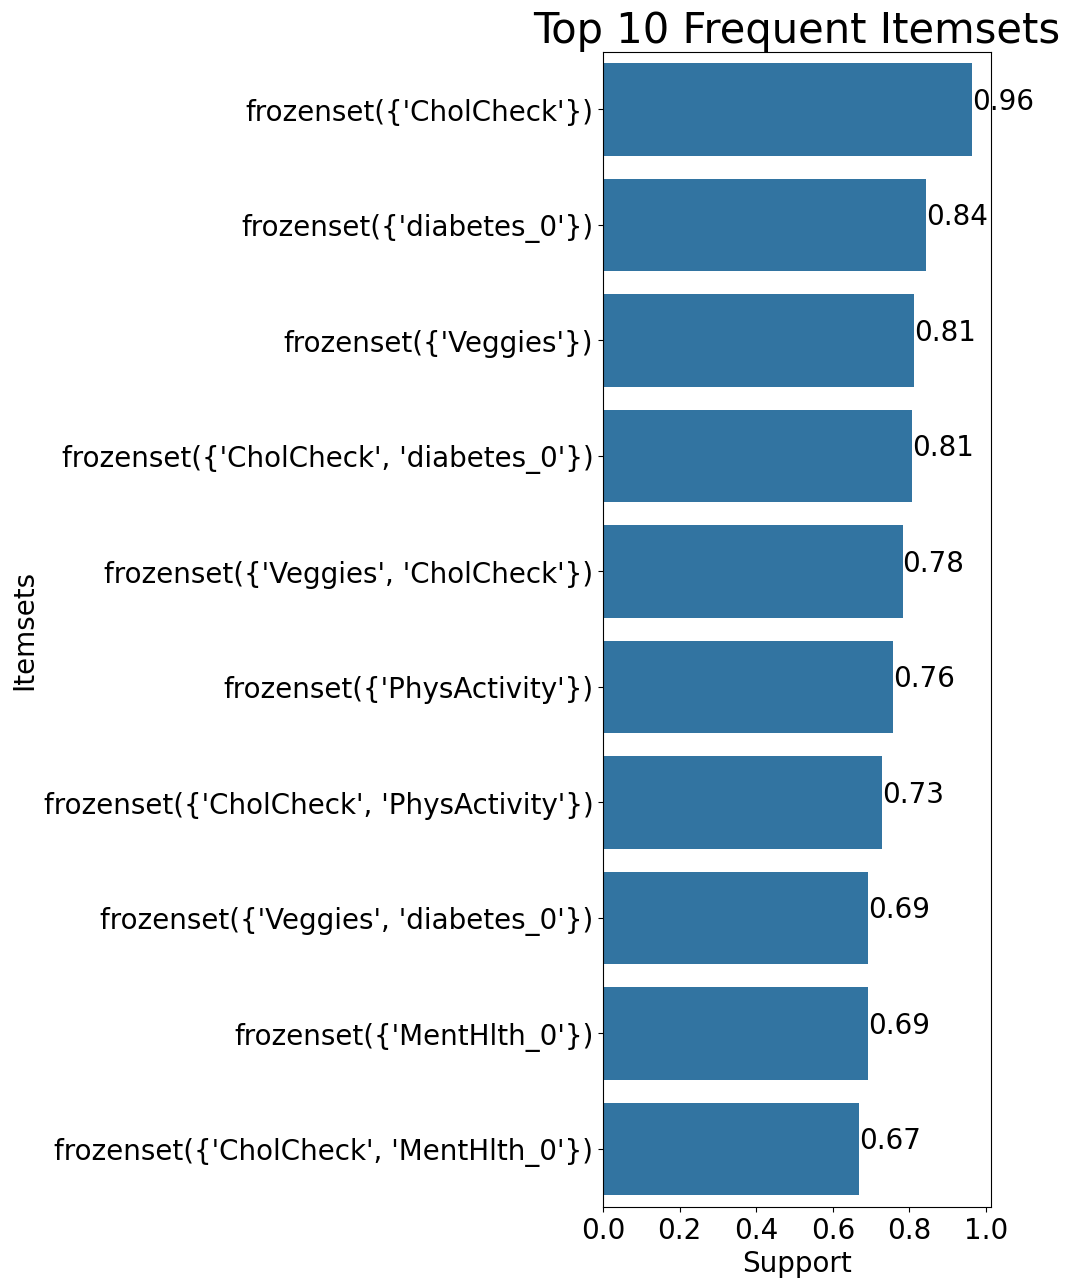

In [68]:
#Create an item frequency plot for the top 20 most frequent itemsets
plt.figure(figsize=(5, 15))
sns.barplot(x='support', y='itemsets', data=frequent_itemsets.nlargest(10, 'support'))
plt.title('Top 10 Frequent Itemsets', fontsize=30)
plt.xlabel('Support', fontsize=20)
plt.ylabel('Itemsets', fontsize=20)
plt.xticks(fontsize=20)  # Adjust fontsize for x-axis ticks
plt.yticks(fontsize=20)  # Adjust fontsize for y-axis ticks
#label the bars
for i in range(10):
    plt.text(frequent_itemsets.nlargest(10, 'support')['support'].iloc[i], i, round(frequent_itemsets.nlargest(10, 'support')['support'].iloc[i], 2), fontsize=20)

# Display the plot
plt.show()




### Generating Association Rules using confidence and lift
Confidence is a good indication of the predictive power of the rule based on a percentage of how often RHS occurs given LHS.
There are no association rules generated where prediabetes and diabetes diagnosis are included in the RHS with a confidence treshold of 0.8 or 0.5. The confidence treshold was therefore lowered to 0.3 to identify associations between lifestyle factors / health conditions and a diabetes diagnosis that meet a lower confidence treshold.

 Lift can provide further insights into the strenght of the rule's relationships and non-random associations. Results are therefore further filtered using a lift of 2 so that only associationn rules where the likelihood of RHS occuring is 2 times higher when LHS lifestyle factors and health conditions are present. 

In [71]:
#Generate the associate rules using confidence of 30% as the metric
rules_diabetes_0 = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.8)
rules_diabetes_1 = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.01)
rules_diabetes_2 = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.2)

#Filter rules based on lift
rules_diabetes_0 = rules_diabetes_0[rules_diabetes_0['lift'] > 1]
rules_diabetes_1 = rules_diabetes_1[rules_diabetes_1['lift'] > 1]
rules_diabetes_2 = rules_diabetes_2[rules_diabetes_2['lift'] > 1]

#Filter rules based on the diabetes diagnosis that is present in the RHS of the rule
rules_diabetes_0 = rules_diabetes_0[rules_diabetes_0['consequents'].apply(lambda x: 'diabetes_0' in str(x))]
rules_diabetes_1 = rules_diabetes_1[rules_diabetes_1['consequents'].apply(lambda x: 'diabetes_1' in str(x))]
rules_diabetes_2 = rules_diabetes_2[rules_diabetes_2['consequents'].apply(lambda x: 'diabetes_2' in str(x))]

## Display results for each diabetes diagnosis

### Display the Rules for No Diabetes / Pregnancy Only

In [53]:
#Display the rules
display(rules_diabetes_0)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
25,(PhysActivity),(diabetes_0),0.757017,0.842833,0.657159,0.868090,1.029966,0.019120,1.191468,0.119738
31,(Fruits),(diabetes_0),0.633783,0.842833,0.541746,0.854781,1.014176,0.007572,1.082273,0.038167
32,(Veggies),(diabetes_0),0.811069,0.842833,0.692337,0.853610,1.012786,0.008741,1.073616,0.066822
42,(BMI_Healthy weight),(diabetes_0),0.272745,0.842833,0.254415,0.932794,1.106736,0.024536,2.338570,0.132611
43,(BMI_Overweight),(diabetes_0),0.368527,0.842833,0.320790,0.870465,1.032784,0.010183,1.213310,0.050268
...,...,...,...,...,...,...,...,...,...,...
2725,"(MentHlth_0, PhysHlth_0, CholCheck, Fruits, BM...","(diabetes_0, Veggies)",0.125237,0.692337,0.100402,0.801700,1.157962,0.013696,1.551502,0.155944
2726,"(MentHlth_0, PhysHlth_0, Veggies, Fruits, BMI_...","(diabetes_0, CholCheck)",0.115721,0.807419,0.100402,0.867625,1.074566,0.006967,1.454816,0.078473
2729,"(MentHlth_0, PhysHlth_0, CholCheck, Veggies, F...",(diabetes_0),0.116493,0.842833,0.106134,0.911072,1.080963,0.007949,1.767346,0.084775
2731,"(MentHlth_0, PhysHlth_0, CholCheck, Fruits, Ge...","(diabetes_0, Veggies)",0.129447,0.692337,0.106134,0.819904,1.184256,0.016513,1.708327,0.178723


In [80]:
# Set Pandas options to display full content of all cells
pd.set_option('display.max_colwidth', None)  # Do not truncate column content
pd.set_option('display.max_rows', None)     # Display all rows (if necessary)

# Display the rules sorted by highest support
print(rules_diabetes_0.sort_values(by='support', ascending=False))


                                                                        antecedents  \
32                                                                        (Veggies)   
148                                                                       (Veggies)   
145                                                            (Veggies, CholCheck)   
25                                                                   (PhysActivity)   
112                                                                  (PhysActivity)   
110                                                       (CholCheck, PhysActivity)   
46                                                                     (MentHlth_0)   
186                                                         (CholCheck, MentHlth_0)   
188                                                                    (MentHlth_0)   
244                                                         (Veggies, PhysActivity)   
48                                         

In [79]:
# Display the rules sorted by highest confidence
print(rules_diabetes_0.sort_values(by='confidence', ascending=False))


                                                                        antecedents  \
1874                             (Veggies, Fruits, GenHlth_Excellent, PhysActivity)   
2219                  (GenHlth_Excellent, CholCheck, PhysActivity, Veggies, Fruits)   
920                                       (Fruits, GenHlth_Excellent, PhysActivity)   
1953                         (Veggies, PhysHlth_0, GenHlth_Excellent, PhysActivity)   
1057                                        (PhysHlth_0, Fruits, GenHlth_Excellent)   
1028                                           (Veggies, Fruits, GenHlth_Excellent)   
1422                           (CholCheck, Fruits, GenHlth_Excellent, PhysActivity)   
2387              (PhysHlth_0, GenHlth_Excellent, CholCheck, PhysActivity, Veggies)   
947                                      (Veggies, GenHlth_Excellent, PhysActivity)   
1722                             (CholCheck, PhysHlth_0, Fruits, GenHlth_Excellent)   
1006                                  (Phys

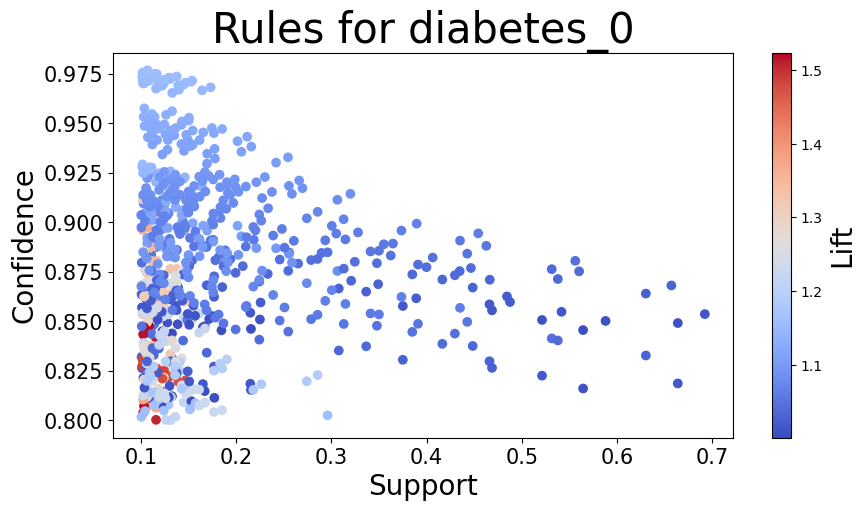

In [54]:
#create plot for rules_diabetes_0 with support as x axis and lift as y axis, and colours the confidence and plot all the antecedents
plt.figure(figsize=(10, 5))
scatter = plt.scatter(rules_diabetes_0['support'], rules_diabetes_0['confidence'], c=rules_diabetes_0['lift'], cmap='coolwarm')
cbar = plt.colorbar(scatter)
cbar.set_label('Lift', fontsize=20) 
plt.title('Rules for diabetes_0', fontsize = 30)
plt.xlabel('Support', fontsize = 20)
plt.ylabel('Confidence', fontsize = 20)
plt.xticks(fontsize=15)  
plt.yticks(fontsize=15)
plt.show()


C:\Users\steph\AppData\Local\Temp\ipykernel_19440\2057699250.py:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=2.0)  # Add more padding to avoid clipping labels


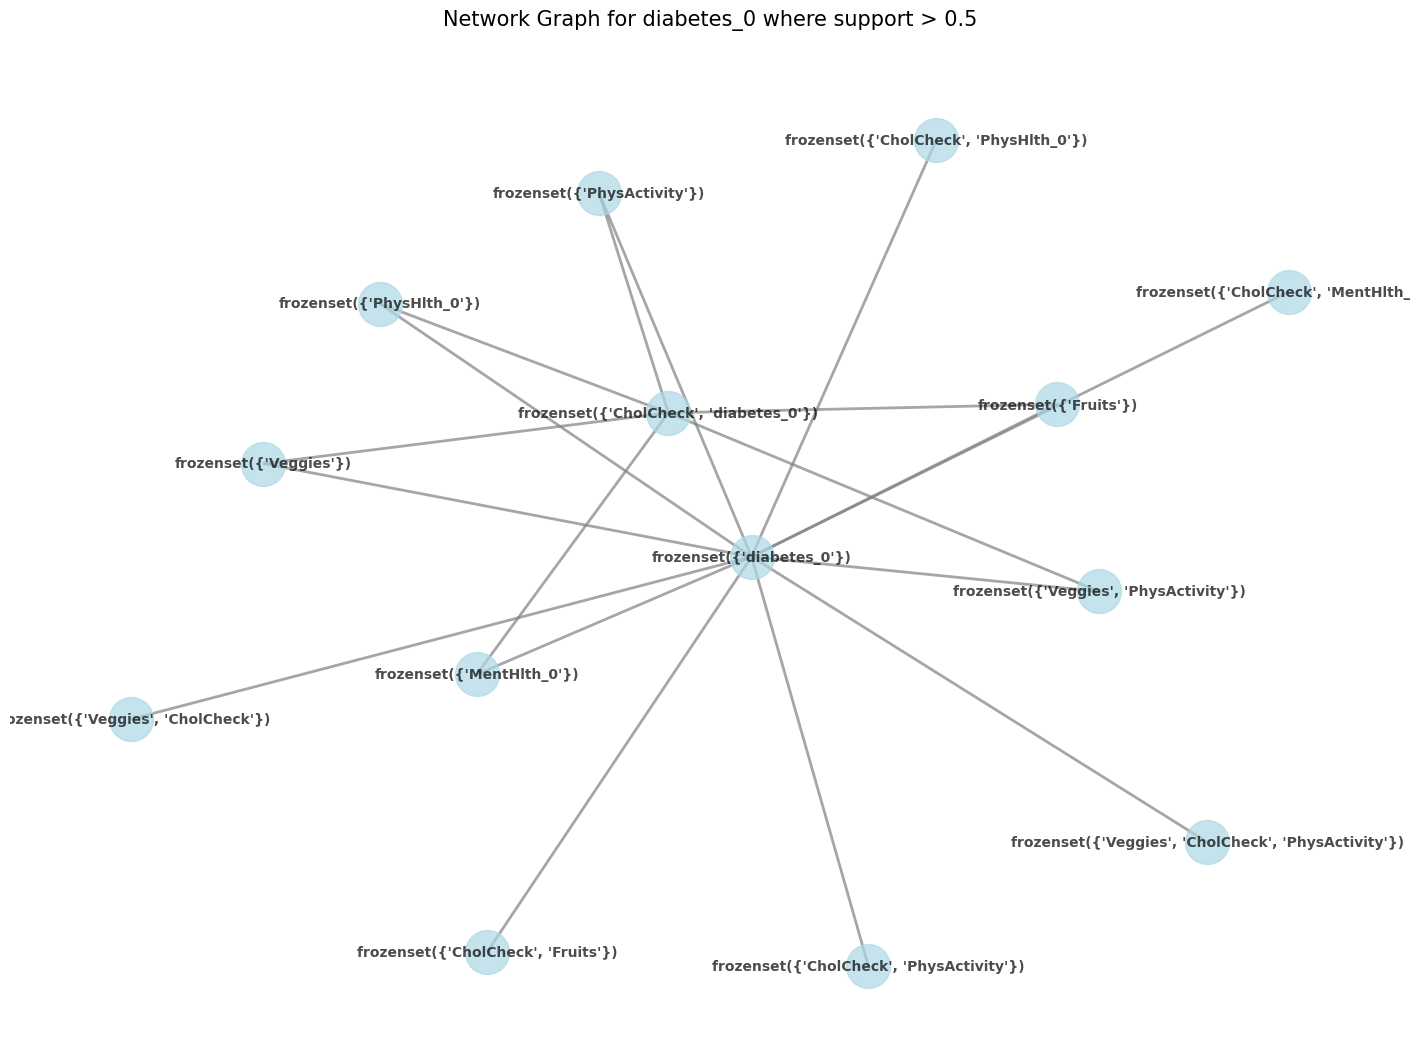

In [55]:
# Create a network graph for the rules_diabetes_0 where support is above 0.5
G = nx.from_pandas_edgelist(rules_diabetes_0[rules_diabetes_0['support'] > 0.5], source='antecedents', target='consequents')

# Set up the plot with a larger figure size to accommodate the graph
plt.figure(figsize=(14, 10))  # Increase the figsize further if needed

# Generate positions for the nodes using spring layout (or try another layout like `circular_layout`)
pos = nx.spring_layout(G, k=0.2, iterations=20)  # Adjust the `k` parameter for spacing between nodes

# Draw the graph with larger and lighter blue nodes, and ensure the labels are not cut off
nx.draw(G, 
        pos,  # Use the calculated positions to layout the nodes
        with_labels=True, 
        node_size=1000,  # Increase node size
        node_color='lightblue',  # Lighter blue color for the nodes
        font_size=10,  # Font size for the labels
        font_weight='bold',  # Bold font for better readability
        width=2,  # Thicker edges for better visibility
        edge_color='gray',  # Lighter color for the edges
        alpha=0.7)  # Adjust transparency if needed

# Add title and display the plot
plt.title('Network Graph for diabetes_0 where support > 0.5', fontsize=15, pad=20)  # Added padding for the title
plt.tight_layout(pad=2.0)  # Add more padding to avoid clipping labels
plt.show()

C:\Users\steph\AppData\Local\Temp\ipykernel_19440\3248480134.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=2.0)


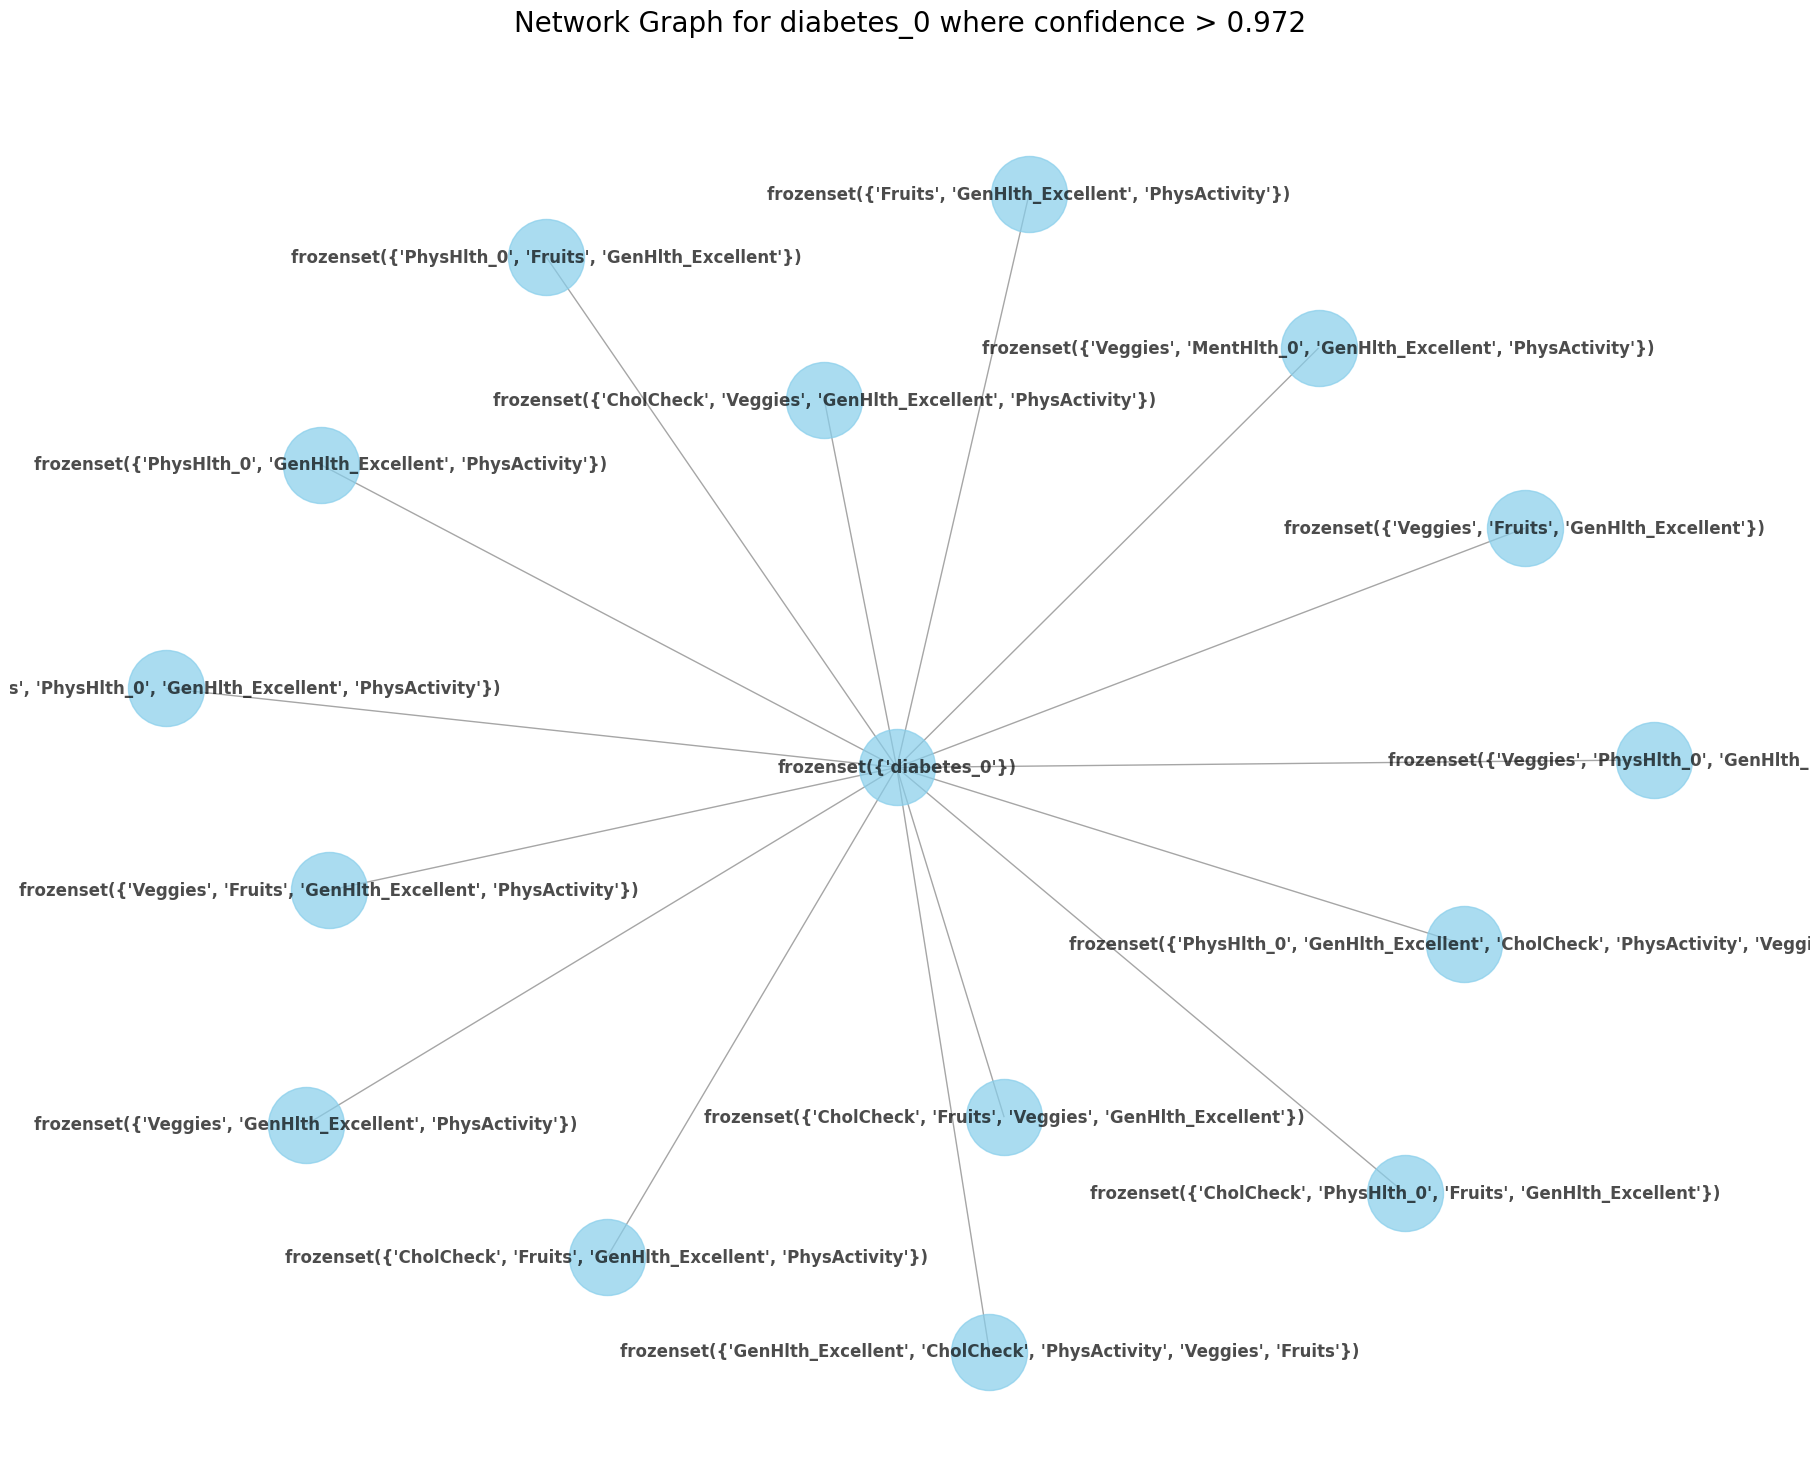

In [ ]:
# Create a network graph for the rules_diabetes_0 where confidence is above 97.2%
G = nx.from_pandas_edgelist(rules_diabetes_0[rules_diabetes_0['confidence'] > 0.972], source='antecedents', target='consequents')

# Set up the plot with a larger figure size to accommodate the graph
plt.figure(figsize=(18, 14))  # Increase the figure size further

# Generate positions for the nodes using spring layout (or try a different layout)
pos = nx.spring_layout(G, k=0.3, iterations=50, seed=42)  # Increased iterations for better spacing

# Draw the graph with larger nodes, a light blue color, and better font sizes
nx.draw(G, 
        pos,  # Use the calculated positions to layout the nodes
        with_labels=True, 
        node_size=3000,  # Increase node size
        node_color='skyblue',  # Lighter color for the nodes
        font_size=12,  # Increase font size for the labels
        font_color='black',  # Black font color for better readability
        font_weight='bold',  # Bold font for labels
        width=1,  # Thinner edges for better visibility
        edge_color='gray',  # Light color for edges to reduce clutter
        alpha=0.7)  # Slight transparency for nodes and edges

# Add title and adjust padding to avoid clipping
plt.title('Network Graph for diabetes_0 where confidence > 0.972', fontsize=20, pad=30)  # Increased padding for the title

# Adjust margins further to avoid cutting off any labels
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)

# Automatically adjust layout to ensure no clipping of labels
plt.tight_layout(pad=2.0)

# Display the plot
plt.show()

### Display the Rules for Pre Diabetes Diagnosis

In [72]:
#Display the rules
display(rules_diabetes_1)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric


### Display the Rules for Diabetes Diagnosis

In [58]:
#Display the rules 
display(rules_diabetes_2)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
16,(HighBP),(diabetes_2),0.427980,0.139254,0.104959,0.245243,1.761116,0.045361,1.140427,0.755530
303,"(HighBP, CholCheck)",(diabetes_2),0.421539,0.139254,0.104447,0.247774,1.779296,0.045745,1.144265,0.757147
306,(HighBP),"(CholCheck, diabetes_2)",0.427980,0.138411,0.104447,0.244045,1.763198,0.045210,1.139737,0.756702


In [75]:
display(rules_diabetes_2[['antecedents', 'consequents', 'support', 'confidence', 'lift']])


,antecedents,consequents,support,confidence,lift
16,(HighBP),(diabetes_2),0.104959,0.245243,1.761116
303,"(HighBP, CholCheck)",(diabetes_2),0.104447,0.247774,1.779296
306,(HighBP),"(CholCheck, diabetes_2)",0.104447,0.244045,1.763198


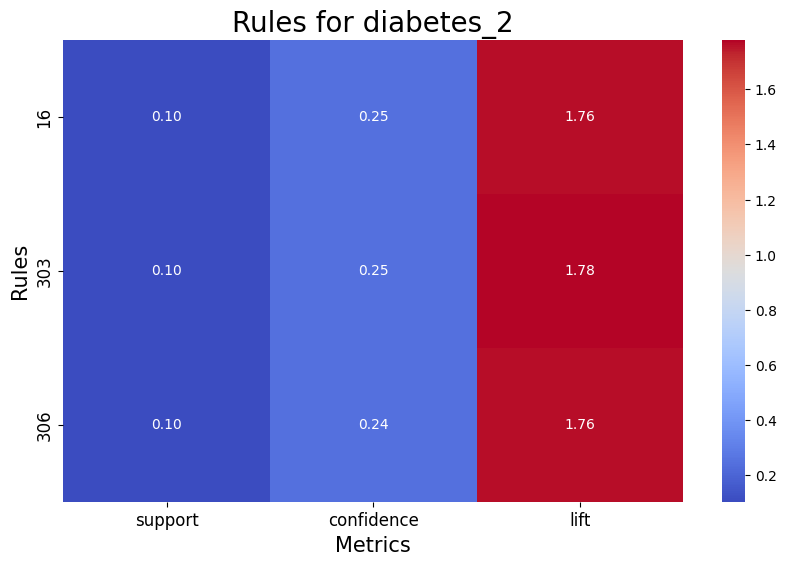

In [60]:
# Display the rules_diabetes_2 in a heatmap with support, confidence, and lift as the values and the antecedents and consequents combined as the as rows
# Create the heatmap for rules_diabetes_2 with support, confidence, and lift as the values
plt.figure(figsize=(10, 6))
sns.heatmap(rules_diabetes_2[['support', 'confidence', 'lift']], annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Rules for diabetes_2', fontsize=20)
plt.xlabel('Metrics', fontsize=15)
plt.ylabel('Rules', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


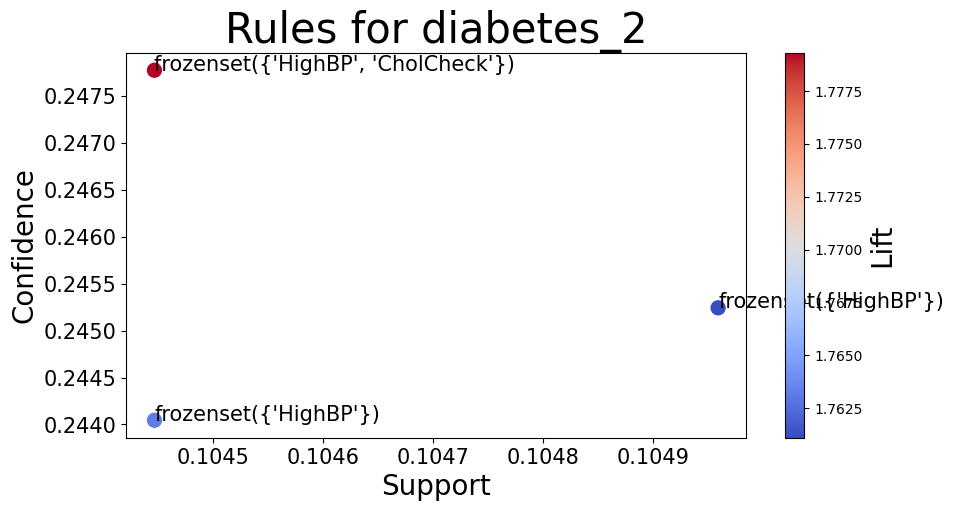

In [73]:
#create plot for rules_diabetes_2 with support as x axis and lift as y axis, and colours the confidence and label all the antecedents
plt.figure(figsize=(10, 5))
scatter = plt.scatter(rules_diabetes_2['support'], rules_diabetes_2['confidence'], c=rules_diabetes_2['lift'], cmap='coolwarm', s=100)
cbar = plt.colorbar(scatter)
cbar.set_label('Lift', fontsize=20) 
plt.title('Rules for diabetes_2', fontsize=30)
plt.xlabel('Support', fontsize=20)
plt.ylabel('Confidence', fontsize=20)
plt.xticks(fontsize=15)  
plt.yticks(fontsize=15)
#label the antecedents
for i, txt in enumerate(rules_diabetes_2['antecedents']):
    plt.annotate(txt, (rules_diabetes_2['support'].iloc[i], rules_diabetes_2['confidence'].iloc[i]), fontsize=15)
plt.show()


C:\Users\steph\AppData\Local\Temp\ipykernel_19440\3542983665.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=2.0)


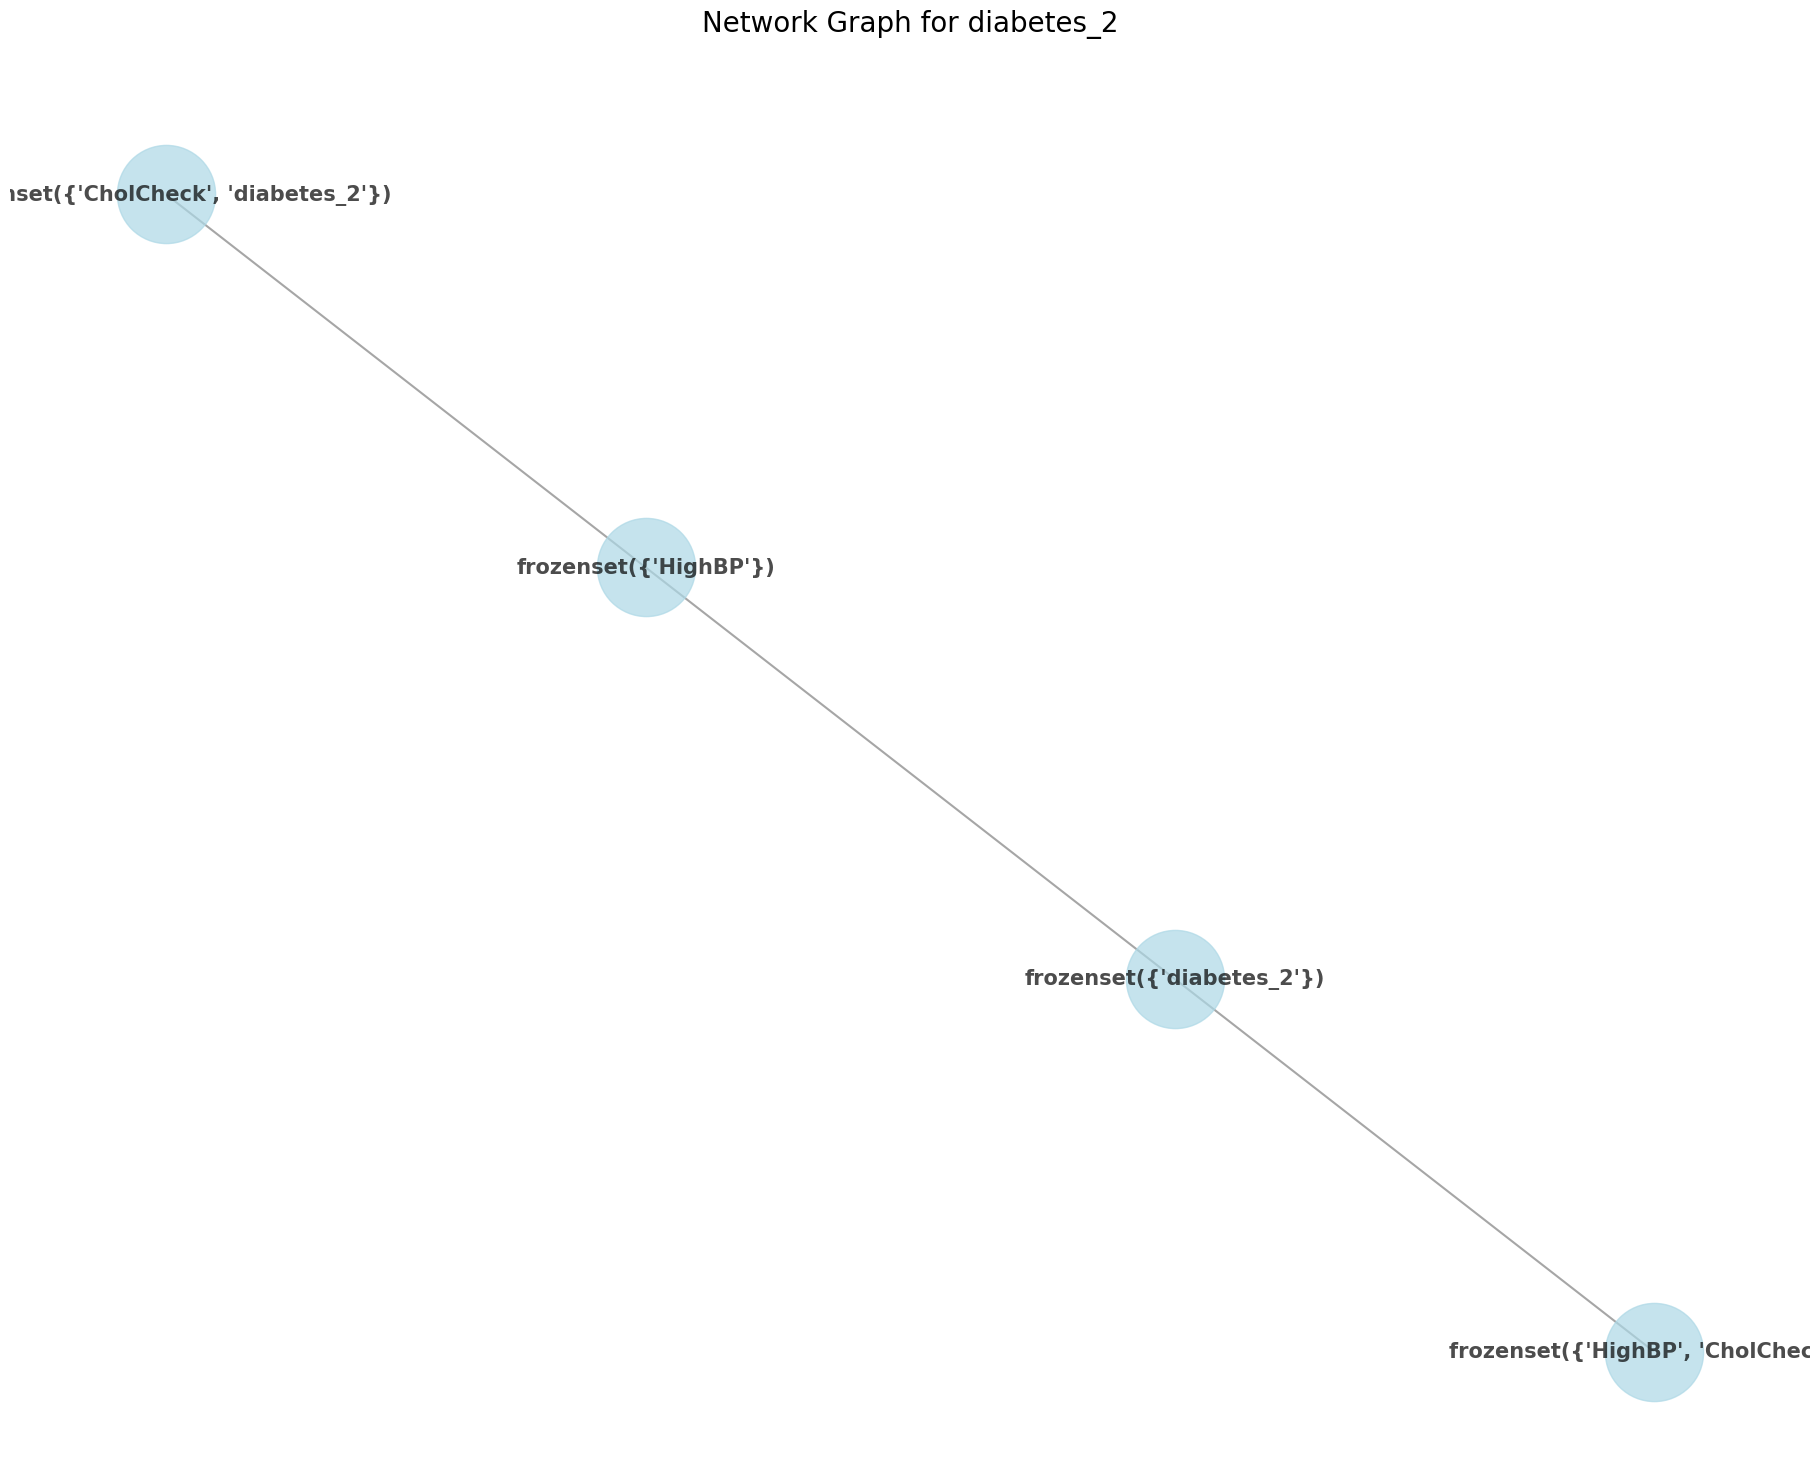

In [62]:
# Create a network graph for the rules_diabetes_2
G = nx.from_pandas_edgelist(rules_diabetes_2, source='antecedents', target='consequents')

# Set up the plot with a larger figure size to accommodate the graph
plt.figure(figsize=(18, 14))  # Increase the figure size further for better readability

# Generate positions for the nodes using spring layout with adjustments for better spacing
pos = nx.spring_layout(G, k=0.5, iterations=100, seed=42)  # Adjust `k` for better spacing and increase iterations

# Draw the graph with larger nodes, a light blue color, and better font sizes
nx.draw(G, 
        pos,  # Use the calculated positions for better layout
        with_labels=True, 
        node_size=5000,  # Larger node size
        node_color='lightblue',  # Light color for the nodes
        font_size=15,  # Increase font size for the labels
        font_color='black',  # Black font for better readability
        font_weight='bold',  # Bold font for labels
        width=1.5,  # Thicker edges for better visibility
        edge_color='gray',  # Lighter edge color to reduce clutter
        alpha=0.7)  # Slight transparency for nodes and edges

# Add title with larger font size and padding
plt.title('Network Graph for diabetes_2', fontsize=20, pad=30)

# Adjust margins further to avoid cutting off any labels
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)

# Automatically adjust layout to ensure no clipping of labels
plt.tight_layout(pad=2.0)

# Display the plot
plt.show()


## Visualizing the Results

Visualizing the most frrequent itemsets by support

In [63]:
# Combine the results into one DataFrame, adding a new column for the type of diabetes diagnosis
rules_diabetes_0['diabetes_type'] = 'diabetes_0'
rules_diabetes_1['diabetes_type'] = 'diabetes_1'
rules_diabetes_2['diabetes_type'] = 'diabetes_2'

# Concatenate the three DataFrames into one
combined_rules = pd.concat([rules_diabetes_0, rules_diabetes_1, rules_diabetes_2])

# Preview the combined data
combined_rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric,diabetes_type
25,(PhysActivity),(diabetes_0),0.757017,0.842833,0.657159,0.868090,1.029966,0.019120,1.191468,0.119738,diabetes_0
31,(Fruits),(diabetes_0),0.633783,0.842833,0.541746,0.854781,1.014176,0.007572,1.082273,0.038167,diabetes_0
32,(Veggies),(diabetes_0),0.811069,0.842833,0.692337,0.853610,1.012786,0.008741,1.073616,0.066822,diabetes_0
42,(BMI_Healthy weight),(diabetes_0),0.272745,0.842833,0.254415,0.932794,1.106736,0.024536,2.338570,0.132611,diabetes_0
43,(BMI_Overweight),(diabetes_0),0.368527,0.842833,0.320790,0.870465,1.032784,0.010183,1.213310,0.050268,diabetes_0


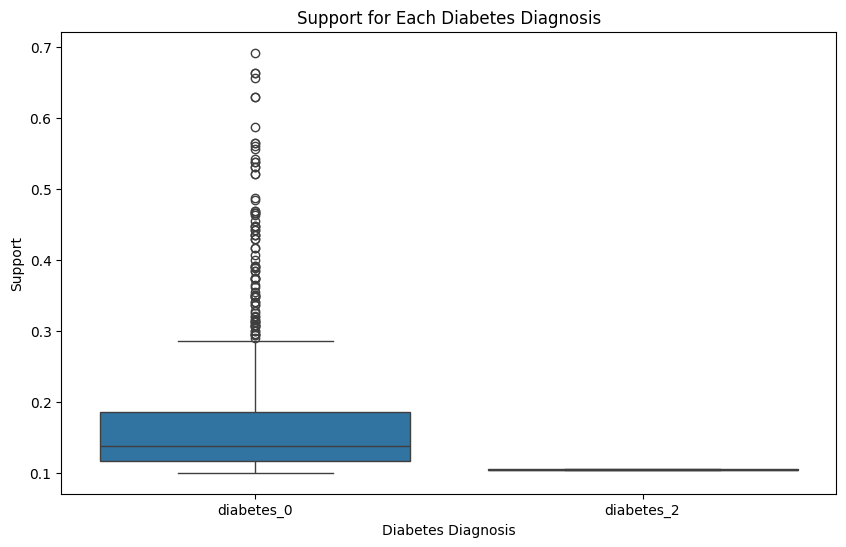

In [64]:
#Create a box plot to visualize support for each diabetes diagnosis
plt.figure(figsize=(10, 6))
sns.boxplot(x='diabetes_type', y='support', data=combined_rules)
plt.title('Support for Each Diabetes Diagnosis')
plt.ylabel('Support')
plt.xlabel('Diabetes Diagnosis')
plt.show()


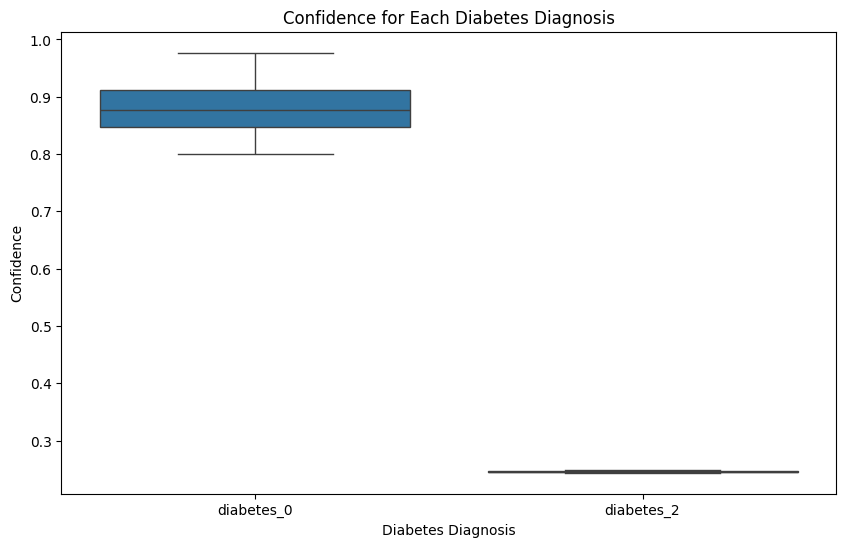

In [65]:
#Create a box plot for confidence for each diabetes diagnosis
plt.figure(figsize=(10, 6))
sns.boxplot(x='diabetes_type', y='confidence', data=combined_rules)
plt.title('Confidence for Each Diabetes Diagnosis')
plt.ylabel('Confidence')
plt.xlabel('Diabetes Diagnosis')
plt.show()



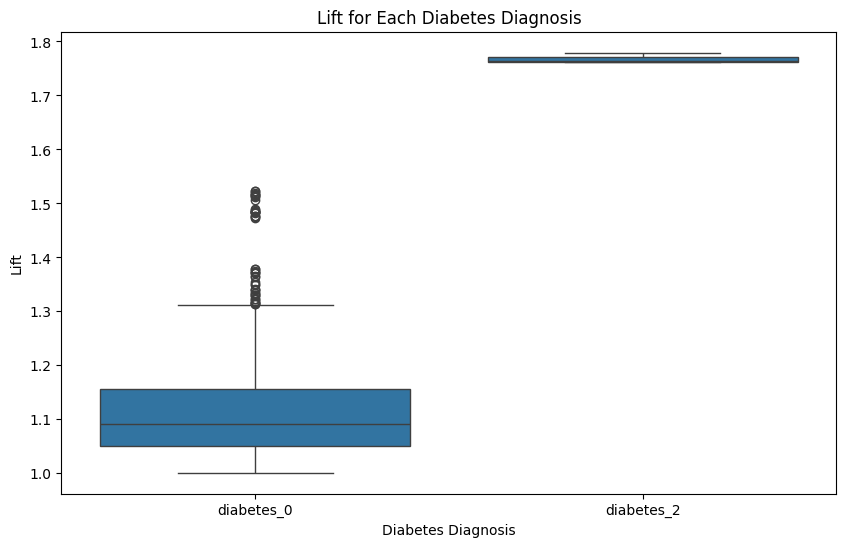

In [66]:
#Create a plot for the lift for each diabetes diagnosis
plt.figure(figsize=(10, 6))
sns.boxplot(x='diabetes_type', y='lift', data=combined_rules)
plt.title('Lift for Each Diabetes Diagnosis')
plt.ylabel('Lift')
plt.xlabel('Diabetes Diagnosis')
plt.show()



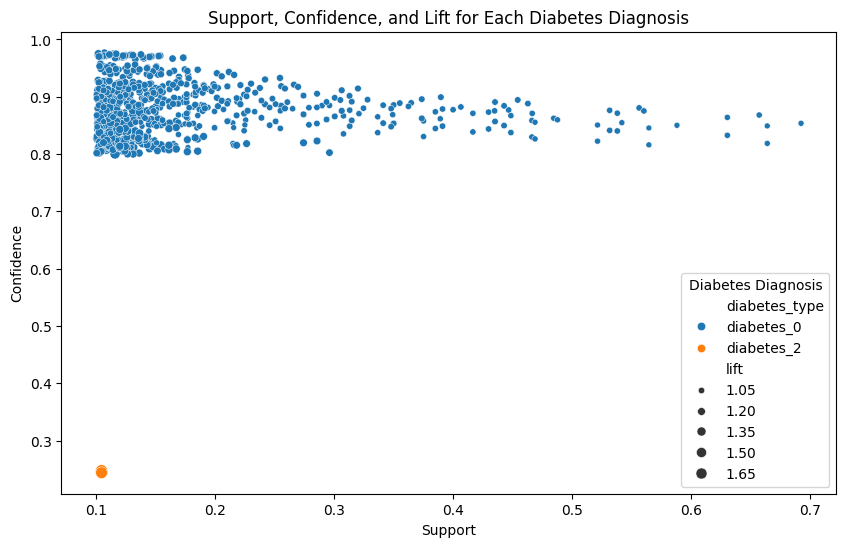

In [67]:
#Create a visualization to show the antcedents, support, confidence, and lift for each diabetes diagnosis and label the antecedents

plt.figure(figsize=(10, 6))
sns.scatterplot(x='support', y='confidence', hue='diabetes_type', size='lift', data=combined_rules)
plt.title('Support, Confidence, and Lift for Each Diabetes Diagnosis')
plt.ylabel('Confidence')
plt.xlabel('Support')
plt.legend(title='Diabetes Diagnosis')

plt.show()
